In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# from sklearn.tree import DecisionTreeClassifier


song_data = pd.read_csv("data/song_data.csv")
song_info = pd.read_csv("data/song_info.csv")

song_data.head()
# song_info.head()
# song_data['song_popularity']

# What score constitutes the upper 20% of song popularity?
popularity_percentile = 80
pop_crit = np.percentile(song_data['song_popularity'],popularity_percentile)
print(pop_crit)

72.0


In [4]:
song_data.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [5]:
from sklearn.model_selection import train_test_split

# currently the pop_crit is popularity score of 72+
class_labels = song_data['song_popularity'].apply(lambda x: 1 if x >= pop_crit else 0)  #song_data.pop("is_popular")
scores = song_data.pop("song_popularity")
names = song_data.pop("song_name") # Get rid of name column
# 
X = np.array(song_data)
y = np.array(class_labels)
z = np.array(scores)

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   train_size = 0.85,
                                                   random_state = 123,
                                                   )#stratify = y)


In [3]:
# Train a Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 15,random_state = 123)#criterion = 'gini',max_depth = 30)#max_depth = 12)
dt.fit(X_train,y_train)


print(np.mean(dt.predict(X_test) == y_test))

0.8598726114649682


In [4]:
# Grid Search for the DT
from sklearn.model_selection import GridSearchCV


param_grid = [{'max_depth': [8, 12, 16, 20, 24,30,100, None],
               'criterion': ['gini', 'entropy']}]

gsdt = GridSearchCV(estimator=DecisionTreeClassifier(random_state = 123),
                  param_grid=param_grid,
                  refit=True,
                  cv=10,
                  n_jobs=None)

gsdt.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gsdt.best_score_*100))
print('Best Params:', gsdt.best_params_)

Best Accuracy: 86.66%
Best Params: {'criterion': 'entropy', 'max_depth': 100}


In [5]:
for i in range(len(gsdt.cv_results_['mean_test_score'])):
    print(gsdt.cv_results_['mean_test_score'][i],gsdt.cv_results_['params'][i])

0.8116054419113053 {'criterion': 'gini', 'max_depth': 8}
0.837653419737664 {'criterion': 'gini', 'max_depth': 12}
0.8578299890693317 {'criterion': 'gini', 'max_depth': 16}
0.8607034665833855 {'criterion': 'gini', 'max_depth': 20}
0.8662629996876952 {'criterion': 'gini', 'max_depth': 24}
0.866326085259213 {'criterion': 'gini', 'max_depth': 30}
0.8662010462211118 {'criterion': 'gini', 'max_depth': 100}
0.8662010462211118 {'criterion': 'gini', 'max_depth': None}
0.8059214943785135 {'criterion': 'entropy', 'max_depth': 8}
0.8274088069956278 {'criterion': 'entropy', 'max_depth': 12}
0.8481471736414742 {'criterion': 'entropy', 'max_depth': 16}
0.8567674109931293 {'criterion': 'entropy', 'max_depth': 20}
0.8625770612117428 {'criterion': 'entropy', 'max_depth': 24}
0.8665754216114928 {'criterion': 'entropy', 'max_depth': 30}
0.8666379216114928 {'criterion': 'entropy', 'max_depth': 100}
0.8666379216114928 {'criterion': 'entropy', 'max_depth': None}


In [6]:
# # Let's get an estimate for the true generalization accuracy of this model
# from mlxtend.evaluate import bootstrap_point632_score

# point632_est = bootstrap_point632_score(clf, 
#                             X_train, y_train, 
#                             n_splits=100, 
#                             method='.632+',
#                             random_seed=123)

# np.mean(point632_est)

In [7]:
# Use a bagging classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

base = DecisionTreeClassifier(max_depth = 15,
                              criterion = 'entropy',
                             random_state = 1)

bag = BaggingClassifier(base,
                       n_estimators = 500,
                       random_state = 1)

    
bag.fit(X_train,y_train)
np.mean(bag.predict(X_test) == y_test)

0.9249823071479123

In [8]:
np.mean(bag.predict(X_test))

0.15074309978768577

In [27]:
%timeit np.mean(dt.predict(X_test))

2.15 ms ± 968 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

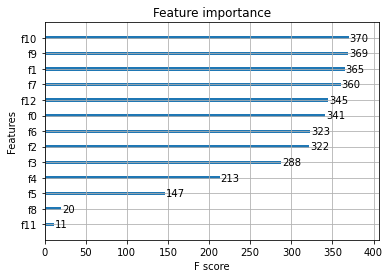

In [11]:
from xgboost import XGBClassifier
from xgboost import plot_importance

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

plot_importance(model)

In [34]:
select = np.array(['song_duration_ms','tempo','loudness'])

# song_data[select]
song_data[select]

,song_duration_ms,tempo,loudness
0,262333,167.060,-4.095
1,216933,105.256,-6.407
2,231733,123.881,-7.828
3,216933,122.444,-4.938
4,223826,172.011,-5.065
...,...,...,...
18830,159645,113.969,-16.107
18831,205666,94.286,-14.078
18832,182211,130.534,-12.222
18833,352280,106.063,-12.020


In [ ]:
import numpy as np
from mlxtend.evaluate import mcnemar_table

# # The correct target (class) labels
# y_target = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

# # Class labels predicted by model 1
# y_model1 = np.array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0])

# # Class labels predicted by model 2
# y_model2 = np.array([0, 0, 1, 1, 0, 1, 1, 0, 0, 0])

# tb = mcnemar_table(y_target=y_test, 
#                    y_model1= bag.predict(X_test), 
#                    y_model2= RandomForest.predict(X_test))
